# Multitask Regression/Classification Network State Reconstruction Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [1]:
!pip install qsttoolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 20.2 MB/s eta 0:00:00


## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We first create batches of optical quantum state vectors of seven different varieties. `qsttoolkit.data` provides classes to produce such batches, each state with randomised parameters within given limits, based on the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework:

In [3]:
dim = 32

fock_batch = qst.data.FockStates(n_states = 1000,
                                 N = dim,
                                 n_range = [0, dim])
coherent_batch = qst.data.CoherentStates(n_states = 1000,
                                         N = dim,
                                         alpha_magnitude_range = [1e-6, 3])
thermal_batch = qst.data.ThermalStates(n_states = 1000,
                                       N = dim,
                                       nbar_range = [0, dim])
num_batch = qst.data.NumStates(n_states = 1000,
                               N = dim,
                               types = ['17', 'M', 'P', 'P2', 'M2'])
binomial_batch = qst.data.BinomialStates(n_states = 1000,
                                         N = dim,
                                         S_range = [1, 10],
                                         mu_range = [0, 2])
cat_batch = qst.data.CatStates(n_states = 1000,
                               N = dim,
                               alpha_magnitude_range = [0, 10])
random_batch = qst.data.RandomStates(n_states = 1000,
                                     N = dim)
print('States generated')

/usr/local/lib/python3.11/dist-packages/qsttoolkit/data/state_batches.py:149: UserWarning: thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


States generated


/usr/local/lib/python3.11/dist-packages/qsttoolkit/data/state_batches.py:333: UserWarning: Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Parameters for noise sources that are applied to the density matrix and Husimi-Q representation:

In [4]:
mixed_state_noise_noise_level = 0.3   # Mixed state noise coefficient
affine_theta = 30                     # Maximum affine transformation theta
affine_x = 0.1                        # Maximum affine transformation x shift
affine_y = 0.1                        # Maximum affine transformation y shift
additive_Gaussian_stddev = 0.01       # Additive Gaussian noise distribution standard deviation
salt_and_pepper_prob = 0.1            # Salt and pepper noise pixel cutout probability

We initialise the Husimi-Q phase space before creating measurement data:

In [5]:
latent_dim = 32
xgrid = np.linspace(-5, 5, latent_dim)
pgrid = np.linspace(-5, 5, latent_dim)

We then create density matrices and Husimi-Q measurement images, applying mixed state noise using `qsttoolkit.data.mixed_state_noise()` and measurement noise using `qsttoolkit.data.apply_measurement_noise()`:

In [6]:
fock_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
coherent_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
thermal_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
num_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
binomial_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
cat_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
random_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
print("DataFrames initialised")

fock_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in fock_batch.density_matrices()]
fock_data['label'] = ['fock']*len(fock_densities)
fock_data['density_matrix'] = [dm.full() for dm in fock_densities]
fock_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in fock_densities]
fock_data['state_parameter'] = fock_batch.params
print("Fock data generated")

coherent_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in coherent_batch.density_matrices()]
coherent_data['label'] = ['coherent']*len(coherent_densities)
coherent_data['density_matrix'] = [dm.full() for dm in coherent_densities]
coherent_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in coherent_densities]
coherent_data['state_parameter'] = coherent_batch.params
print("Coherent data generated")

thermal_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in thermal_batch.density_matrices()]
thermal_data['label'] = ['thermal']*len(thermal_densities)
thermal_data['density_matrix'] = [dm.full() for dm in thermal_densities]
thermal_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in thermal_densities]
thermal_data['state_parameter'] = thermal_batch.params
print("Thermal data generated")

num_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in num_batch.density_matrices()]
num_data['label'] = ['num']*len(num_densities)
num_data['density_matrix'] = [dm.full() for dm in num_densities]
num_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in num_densities]
num_data['state_parameter'] = num_batch.params
print("Num data generated")

binomial_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in binomial_batch.density_matrices()]
binomial_data['label'] = ['binomial']*len(binomial_densities)
binomial_data['density_matrix'] = [dm.full() for dm in binomial_densities]
binomial_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in binomial_densities]
binomial_data['state_parameter'] = binomial_batch.params
print("Binomial data generated")

cat_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in cat_batch.density_matrices()]
cat_data['label'] = ['cat']*len(cat_densities)
cat_data['density_matrix'] = [dm.full() for dm in cat_densities]
cat_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in cat_densities]
cat_data['state_parameter'] = cat_batch.params
print("Cat data generated")

random_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_noise_level) for dm in random_batch.density_matrices()]
random_data['label'] = ['random']*len(random_densities)
random_data['density_matrix'] = [dm.full() for dm in random_densities]
random_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, salt_and_pepper_prob) for dm in random_densities]
random_data['state_parameter'] = random_batch.params
print("Random data generated")

data = pd.concat([fock_data, coherent_data, thermal_data, num_data, binomial_data, cat_data, random_data])
data = data.sample(frac=1).reset_index(drop=True)
print("Dataset generated")

DataFrames initialised
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


Alternatively, QSTToolkit provides the `optical_state_dataset()` function which produces the above dataset in one function, which is intended to be used as a stamdardised dataset for training models:

In [7]:
data = qst.data.optical_state_dataset(dim=32, latent_dim=32)

/usr/local/lib/python3.11/dist-packages/qsttoolkit/data/state_batches.py:149: UserWarning: thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
/usr/local/lib/python3.11/dist-packages/qsttoolkit/data/state_batches.py:333: UserWarning: Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialised as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change

States generated
DataFrames initialised
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


## Modelling

Data preprocessing:

In [23]:
X = data['Husimi-Q_function']

y_class_raw = data['label']
label_encoder = LabelEncoder()
y_class_int = label_encoder.fit_transform(y_class_raw)

y_reg_real = data['state_parameter'].apply(lambda x: x.real)
y_reg_imag = data['state_parameter'].apply(lambda x: x.imag)
y_reg = np.array([y_reg_real, y_reg_imag]).T

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(X, y_class_int, y_reg, test_size=0.2, random_state=42)
y_train = {"classification_output": y_train_class, "regression_output": y_train_reg}    # Dictionaries to handle both regression and classification tasks
y_test = {"classification_output": y_test_class, "regression_output": y_test_reg}
latent_dim = X_train[0].shape[0]
X_train = np.array([x for x in X_train]).reshape(-1, latent_dim, latent_dim, 1)
X_test = np.array([x for x in X_test]).reshape(-1, latent_dim, latent_dim, 1)

We create an instance of the `qsttoolkit.tomography.MultitaskQuantumStateTomography` class, which handles the model architecture, compiling and training:

In [24]:
multitask_model = qst.tomography.MultitaskQuantumStateTomography(dim=32,
                                                                 X_train=X_train,
                                                                 X_test=X_test,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 label_encoder=label_encoder,
                                                                 early_stopping_patience=3,
                                                                 lr_scheduler_factor=0.5,
                                                                 lr_scheduler_patience=4)

Model compiling and training using the `.train` method:

In [25]:
multitask_model.train(optimizer='adam',
                      classification_loss='sparse_categorical_crossentropy', regression_loss='mse',
                      classification_loss_weight=1.0, regression_loss_weight=0.5,
                      classification_metric='accuracy', regression_metric='mae',
                      epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - classification_output_accuracy: 0.1434 - classification_output_loss: 2.1779 - loss: 22.4307 - regression_output_loss: 20.2528 - regression_output_mae: 3.5853 - val_classification_output_accuracy: 0.2375 - val_classification_output_loss: 2.0148 - val_loss: 24.7346 - val_regression_output_loss: 22.7198 - val_regression_output_mae: 3.2633 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - classification_output_accuracy: 0.2958 - classification_output_loss: 1.9415 - loss: 18.9524 - regression_output_loss: 17.0110 - regression_output_mae: 3.2056 - val_classification_output_accuracy: 0.3589 - val_classification_output_loss: 2.2649 - val_loss: 23.1684 - val_regression_output_loss: 20.9035 - val_regression_output_mae: 3.2030 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - classification_output_accuracy: 0.4701 - classification_output_loss: 1.4841 - loss: 16.4734 - regression_outpu

## Analysis and Evaluation

Inspection of accuracy and loss over training epochs:

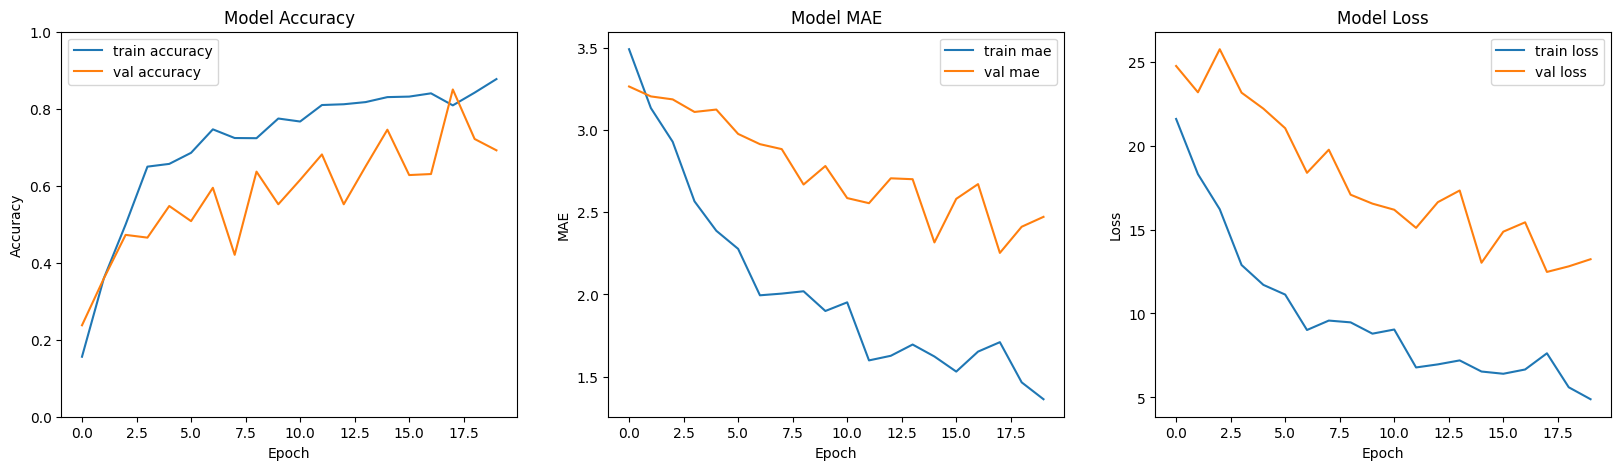

In [26]:
multitask_model.plot_training()

Model evaluation:

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


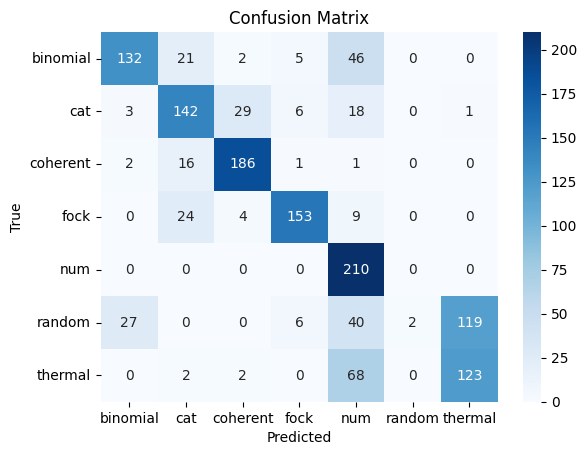

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       206
           1       0.69      0.71      0.70       199
           2       0.83      0.90      0.87       206
           3       0.89      0.81      0.85       190
           4       0.54      1.00      0.70       210
           5       1.00      0.01      0.02       194
           6       0.51      0.63      0.56       195

    accuracy                           0.68      1400
   macro avg       0.75      0.67      0.63      1400
weighted avg       0.75      0.68      0.63      1400



In [27]:
multitask_model.evaluate_classification(include_confusion_matrix=True, include_classification_report=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


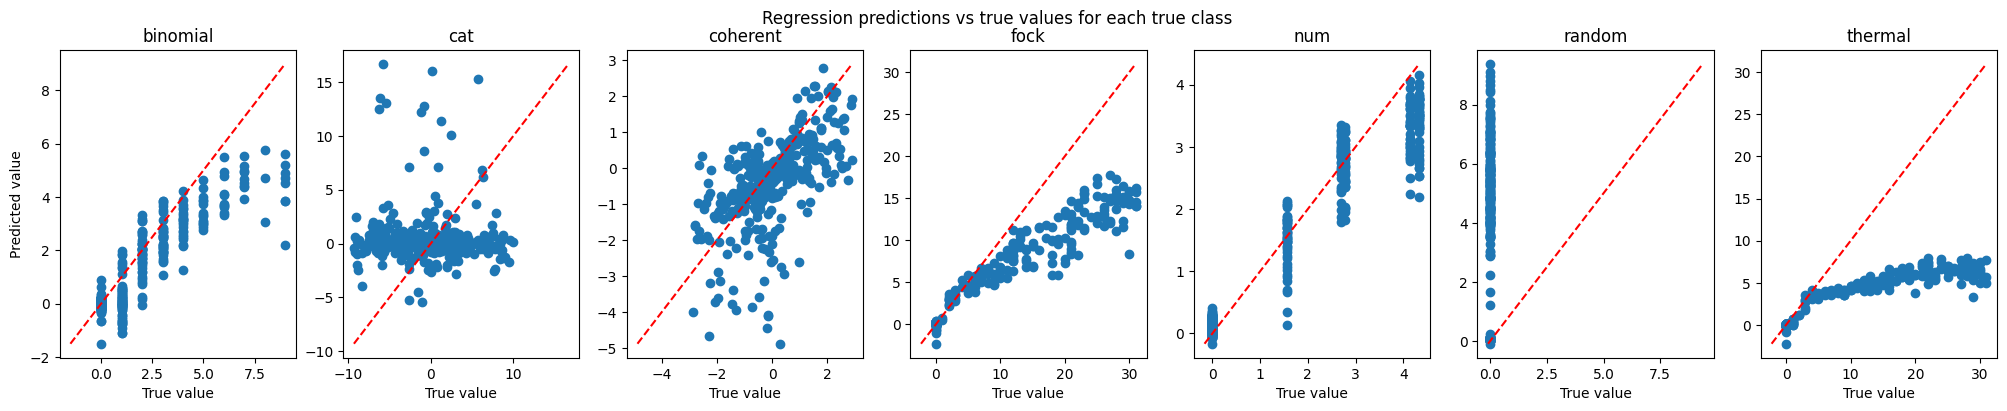

In [28]:
multitask_model.evaluate_regression()

Built-in `.infer` method to infer labels and parameters for given input measurements and invert the label encoding, returning arrays of predicted label strings and parameter values:

In [29]:
print(multitask_model.infer(X_test))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(array(['num', 'coherent', 'num', ..., 'num', 'thermal', 'num'],
      dtype=object), [(2.856934070587158+0.04056365787982941j), (0.6034400463104248+0.6960434913635254j), (3.590094804763794+0.028453337028622627j), (-0.19167378544807434-0.3210974633693695j), (8.639090538024902+0.11677275598049164j), (7.068767547607422+0.06612803041934967j), (7.983211994171143+0.058373644948005676j), (5.395323276519775+0.026721643283963203j), (1.096879005432129+0.04215545952320099j), (6.77170467376709+0.05654282867908478j), (0.12056583166122437+0.030742662027478218j), (4.037721633911133+0.050602614879608154j), (-0.4320458471775055-0.03155495226383209j), (6.161423206329346+0.041946180164813995j), (12.45828628540039+0.19987435638904572j), (2.901674747467041+0.004061909392476082j), (2.346207857131958+0.2022451013326645j), (3.613013505935669-0.02451409213244915j), (3.5618081092834473+0.060306206345558167j), (-0.006132304668426514+0.005857875570654869j), (5.696281909942

`MultitaskQuantumStateTomography.model` can be treated as a `tensorflow.keras.Model` object, for example:

In [30]:
multitask_model.model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_extractor         │ (None, 204800)         │      1,577,248 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │     13,107,264 │ feature_extractor[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_20            │ (None, 64)             │              0 │ dense_8[0][0]          │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ leaky_re_lu_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          8,320 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_21            │ (None, 128)            │              0 │ dense_9[0][0]          │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classification_output     │ (None, 7)              │            903 │ leaky_re_lu_21[0][0]   │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 204807)         │              0 │ feature_extractor[0][… │
│ (Concatenate)             │                        │                │ classification_output… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │     13,107,712 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_22            │ (None, 64)             │              0 │ dense_10[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │          8,320 │ leaky_re_lu_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_23            │ (None, 128)            │              0 │ dense_11[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │         33,024 │ leaky_re_lu_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 256)            │              0 │ dense_12[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├──────────────────────

 Total params: 84,022,589 (320.52 MB)

 Trainable params: 28,007,529 (106.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,015,060 (213.68 MB)

## Reconstructing Density Matrices from Inferred Labels and Parameters

QSTToolkit provides the `StateReconstructor` class which takes lists of inferred state labels and parameters and reconstructs the corresponding density matrices using QuTiP functions:

In [31]:
reconstructor = qst.tomography.StateReconstructor()

predicted_labels, predicted_state_parameters = multitask_model.infer(X_test)

reconstructor.add_data(true_labels = label_encoder.inverse_transform(y_test['classification_output']),
                       predicted_labels = predicted_labels,
                       true_state_parameters = y_test['regression_output'],
                       predicted_state_parameters = predicted_state_parameters,
                       true_states = [test.reshape(32,32) for test in X_test])

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [32]:
reconstructor.restrict_parameters(fock_n_range=[0,32], binomial_S_range=[1,10])

In [33]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_state,reconstructed_state,reconstructed_density_matrix
0,num,num,2.696322,2.856934+0.040564j,2.770352+0.000000j,"[[0.009023359317742624, 0.0030294448656004707,...",NaN,NaN
1,coherent,coherent,1.568174,0.603440+0.696043j,0.603440+0.696043j,"[[0.0013691511909062, 0.011369588741751351, 0....",NaN,NaN
2,thermal,num,7.000000,3.590095+0.028453j,4.149065+0.000000j,"[[0.014774947463659092, 0.006888512950824094, ...",NaN,NaN
3,cat,cat,1.982078,-0.191674-0.321097j,-0.191674-0.321097j,"[[0.05836623424949844, 0.06565867881271892, 0....",NaN,NaN
4,fock,fock,21.000000,8.639091+0.116773j,9.000000+0.000000j,"[[0.007705215858098924, 0.0063846393576358325,...",NaN,NaN


In [34]:
reconstructor.reconstruct(32)

In [35]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_state,reconstructed_state,reconstructed_density_matrix
0,num,num,2.696322,2.856934+0.040564j,2.770352+0.000000j,"[[0.009023359317742624, 0.0030294448656004707,...","Quantum object: dims=[[32], [1]], shape=(32, 1...","Quantum object: dims=[[32], [32]], shape=(32, ..."
1,coherent,coherent,1.568174,0.603440+0.696043j,0.603440+0.696043j,"[[0.0013691511909062, 0.011369588741751351, 0....","Quantum object: dims=[[32], [1]], shape=(32, 1...","Quantum object: dims=[[32], [32]], shape=(32, ..."
2,thermal,num,7.000000,3.590095+0.028453j,4.149065+0.000000j,"[[0.014774947463659092, 0.006888512950824094, ...","Quantum object: dims=[[32], [1]], shape=(32, 1...","Quantum object: dims=[[32], [32]], shape=(32, ..."
3,cat,cat,1.982078,-0.191674-0.321097j,-0.191674-0.321097j,"[[0.05836623424949844, 0.06565867881271892, 0....","Quantum object: dims=[[32], [1]], shape=(32, 1...","Quantum object: dims=[[32], [32]], shape=(32, ..."
4,fock,fock,21.000000,8.639091+0.116773j,9.000000+0.000000j,"[[0.007705215858098924, 0.0063846393576358325,...","Quantum object: dims=[[32], [1]], shape=(32, 1...","Quantum object: dims=[[32], [32]], shape=(32, ..."
